# Estimation of recombination rate by _LDhat_

| **Chrom** | **Size** | **Windows** |
| :----: | :----: | :----: |
| Chr1 | 71919034 | 720 |
| Chr2 | 77118269 | 772 |
| Chr3 | 65231163 | 653 |
| Chr4 | 54887108 | 549 |
| Chr5 | 71106538 | 712 |
| Chr6 | 55699338 | 557 |
| Chr7 | 55564713 | 556 |
| Chr8 | 57431585 | 575 |

In [ ]:
library(data.table)
library(tidyverse)
library(foreach)
library(zoo)

options(scipen=999)

setwd('~/snap_hap/recRate')

### misc

In [2]:
# ## Read all windows recRate estimates in parallel
# recRate = foreach(file = Sys.glob('./windows/*bpen5.res.txt'), 
#         .combine=rbind) %do% {
#     dat = fread(file)
#     dat = dat[-1,]
#     dat
#     # cat(file,'\n')
# }
# # recRate[,Loci := Loci*1000]
# recRate = recRate %>% arrange(Loci, desc=T) %>% distinct(Loci, .keep_all = T)

In [37]:
# fileList = list.files(path='./windows/', pattern='*bpen5.res.txt')
# length(fileList)
# Sys.glob('./windows/*bpen5.res.txt') %>% length()

In [95]:
# chromSize = 55699338
# windowSize = 100000
# windowStart = seq(1, chromSize, windowSize)
# windowEnd = seq(100000, windowSize*length(windowStart), windowSize)

# recRate_Chr6_MF3 = data.table()
# bpen=5

# for (window in 1:557){
#     file = Sys.glob(paste0('~/snap_hap/recRate/Chr6.MF3.pFR.hCov/windows/w', window, '.*bpen', bpen, '.res.txt'))
#     if(length(file) == 1){
#         dat = fread(file)
#         start = windowStart[window]
#         end = windowEnd[window]
#         dat[,Loci := Loci*1000]
#         dat = dat[Loci>=start & Loci<=end]

#         recRate_Chr6_MF3 = rbind(recRate_Chr6_MF3,dat)        
#     }
# }
# str(recRate_Chr6_MF3)

Classes ‘data.table’ and 'data.frame':	2533806 obs. of  5 variables:
 $ Loci    : num  11409 11418 11472 11555 11563 ...
 $ Mean_rho: num  6.14 6.18 6.22 6.25 6.3 ...
 $ Median  : num  6.73 6.74 6.75 6.75 6.76 ...
 $ L95     : num  0.253 0.313 0.342 0.46 0.536 ...
 $ U95     : num  8.05 8.05 8.05 8.05 8.06 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Functions

In [2]:
read_recRate_allWindows = function(chrom, chromSize, windowSize, flank, bpen){

    # chrom = 'Chr6'
    # chromSize = 55699338
    # windowSize = 100000
    # flank = 'MF3.pFR.hCov'
    # bpen = 5
    
    windowStart = seq(1, chromSize, windowSize)
    windowEnd = seq(100000, windowSize*length(windowStart), windowSize)

    dat = data.table()

    for (window in 1:length(windowStart)){

        ## Create fileName
        baseDIR = '~/snap_hap/recRate/'
        fileName_toCheck = paste0(baseDIR, 
                                  paste(chrom, flank, sep='.'), 
                                  '/windows/w', window,  
                                  '.*bpen', bpen, 
                                  '.res.txt')
        fileName = Sys.glob(fileName_toCheck)

        ## Check filename and read if exists
        if(length(fileName) == 1){
            tmp = fread(fileName)
            start = windowStart[window]
            end = windowEnd[window]
            tmp[, Loci:= Loci*1e3]
            tmp = tmp[Loci>=start & Loci<=end]

            dat = rbind(dat, tmp)
        }
    }

    return(dat)
}

In [42]:
get_estimates_windowByPos = function(recRate, PosWindowSize, PosWindowStep, chromSize){
    # Make window start and end list
    PosWindowStart = seq(1, chromSize, PosWindowSize)
    PosWindowEnd = seq(PosWindowStep, length(PosWindowStart)*PosWindowSize, PosWindowSize)

    # Initiate empty recRate data table
    recRate_winByPos = data.table()

    # Calculate estimates for each window
    for (window in 1:length(PosWindowStart)){
        dat = recRate[Loci >= PosWindowStart[window] & Loci <= PosWindowEnd[window]]
        values = dat[, lapply(.SD, mean)]
        recRate_winByPos = rbind(recRate_winByPos, values)
    }

    return(na.omit(recRate_winByPos))
}

## Chr6

In [43]:
# MF3
chr6_MF3_bp5 = read_recRate_allWindows(chrom='Chr6', chromSize=55699338, windowSize=100000, flank='MF3.pFR.hCov', bpen=5)
chr6_MF3_bp10 = read_recRate_allWindows(chrom='Chr6', chromSize=55699338, windowSize=100000, flank='MF3.pFR.hCov', bpen=10)
chr6_MF3_bp20 = read_recRate_allWindows(chrom='Chr6', chromSize=55699338, windowSize=100000, flank='MF3.pFR.hCov', bpen=20)
# str(chr6_MF3_bp5)

In [47]:
# MF3: Estimates in SNP windows
SnpWindowSize = 200
SnpWindowStep = 200
chr6_MF3_bp5_winBySNPs = data.table(rollapply(chr6_MF3_bp5, width=SnpWindowSize, by=SnpWindowStep, align='right', FUN=mean))
chr6_MF3_bp10_winBySNPs = data.table(rollapply(chr6_MF3_bp10, width=SnpWindowSize, by=SnpWindowStep, align='right', FUN=mean))
chr6_MF3_bp20_winBySNPs = data.table(rollapply(chr6_MF3_bp20, width=SnpWindowSize, by=SnpWindowStep, align='right', FUN=mean))

In [48]:
# MF3: Estimates in bp windows
PosWindowSize = 10000
PosWindowStep = 10000
chromSize = 55699338
chr6_MF3_bp5_winByPos = get_estimates_windowByPos(chr6_MF3_bp5, PosWindowSize, PosWindowStep, chromSize)
chr6_MF3_bp10_winByPos = get_estimates_windowByPos(chr6_MF3_bp10, PosWindowSize, PosWindowStep, chromSize)
chr6_MF3_bp20_winByPos = get_estimates_windowByPos(chr6_MF3_bp20, PosWindowSize, PosWindowStep, chromSize)

In [49]:
# YF3
chr6_YF3_bp5 = read_recRate_allWindows(chrom='Chr6', chromSize=55699338, windowSize=100000, flank='YF3.pYe.hCov', bpen=5)
chr6_YF3_bp10 = read_recRate_allWindows(chrom='Chr6', chromSize=55699338, windowSize=100000, flank='YF3.pYe.hCov', bpen=10)
chr6_YF3_bp20 = read_recRate_allWindows(chrom='Chr6', chromSize=55699338, windowSize=100000, flank='YF3.pYe.hCov', bpen=20)
# str(chr6_YF3_bp20)

In [ ]:
# YF3: Estimates in SNP windows
SnpWindowSize = 200
SnpWindowStep = 200
chr6_YF3_bp5_winBySNPs = data.table(rollapply(chr6_YF3_bp5, width=SnpWindowSize, by=SnpWindowStep, align='right', FUN=mean))
chr6_YF3_bp10_winBySNPs = data.table(rollapply(chr6_YF3_bp10, width=SnpWindowSize, by=SnpWindowStep, align='right', FUN=mean))
chr6_YF3_bp20_winBySNPs = data.table(rollapply(chr6_YF3_bp20, width=SnpWindowSize, by=SnpWindowStep, align='right', FUN=mean))

In [ ]:
# Estimates in bp windows
PosWindowSize = 10000
PosWindowStep = 10000
chromSize = 55699338
chr6_YF3_bp5_winByPos = get_estimates_windowByPos(chr6_YF3_bp5, PosWindowSize, PosWindowStep, chromSize)
chr6_YF3_bp10_winByPos = get_estimates_windowByPos(chr6_YF3_bp10, PosWindowSize, PosWindowStep, chromSize)
chr6_YF3_bp20_winByPos = get_estimates_windowByPos(chr6_YF3_bp20, PosWindowSize, PosWindowStep, chromSize)

### Correlations

In [27]:
cat('Correlation between MF3 & YF3')
cor(chr6_MF3_bp5$Mean_rho, chr6_YF3_bp5$Mean_rho)
cor(chr6_MF3_bp10$Mean_rho, chr6_YF3_bp10$Mean_rho)
cor(chr6_MF3_bp20$Mean_rho, chr6_YF3_bp20$Mean_rho)

Correlation between MF3 & YF3

[1] 0.6933908

[1] 0.6990755

[1] 0.6991536

In [18]:
str(chr6_MF3_bp5_winBySNPs)

 num [1:12669, 1:5] 17156 28414 35267 36842 38477 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:5] "Loci" "Mean_rho" "Median" "L95" ...


In [26]:
chr6_MF3_bp5_winBySNPs = data.table(chr6_MF3_bp5_winBySNPs)
chr6_MF3_bp10_winBySNPs = data.table(chr6_MF3_bp10_winBySNPs)
chr6_MF3_bp20_winBySNPs = data.table(chr6_MF3_bp20_winBySNPs)
chr6_YF3_bp5_winBySNPs = data.table(chr6_YF3_bp5_winBySNPs)
chr6_YF3_bp10_winBySNPs = data.table(chr6_YF3_bp10_winBySNPs)
chr6_YF3_bp20_winBySNPs = data.table(chr6_YF3_bp20_winBySNPs)

Warning message in plot.window(...):
“"color" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"color" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"color" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"color" is not a graphical parameter”
Warning message in box(...):
“"color" is not a graphical parameter”
Warning message in title(...):
“"color" is not a graphical parameter”
Warning message in plot.window(...):
“"color" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"color" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"color" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"color" is not a graphical parameter”
Warning message in box(...):
“"color" is not a graphical parameter”
Warning message in title(...):
“"color" is not

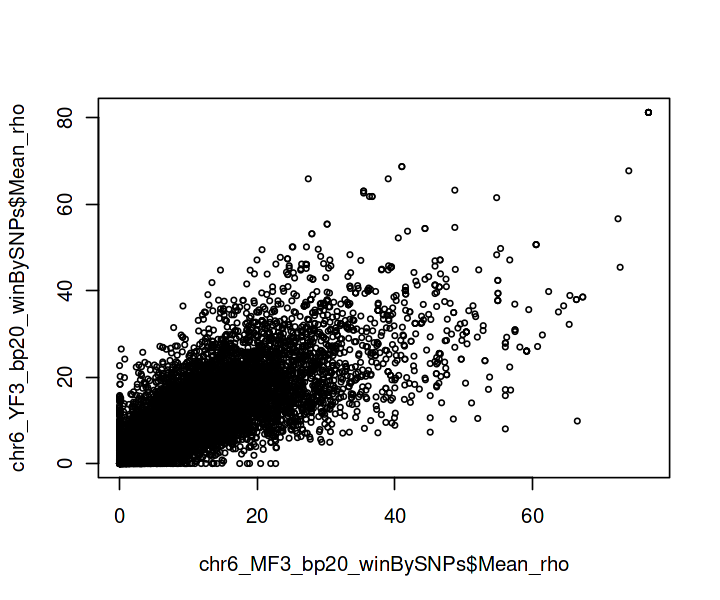

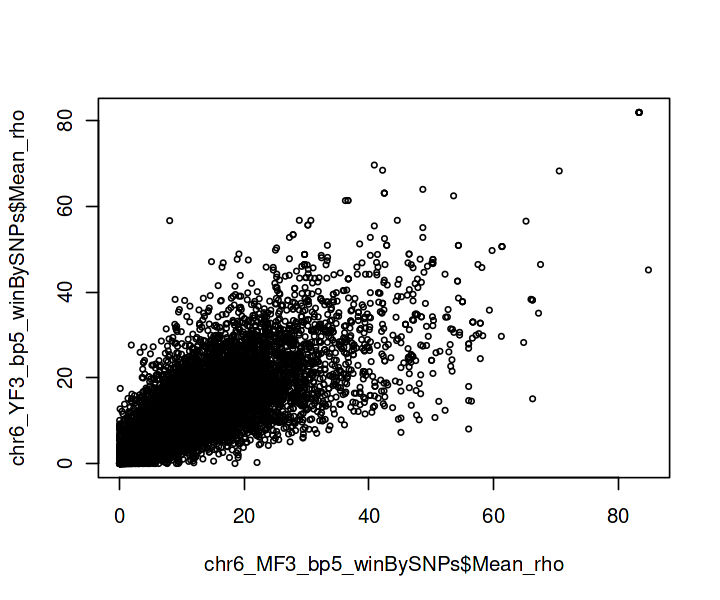

In [30]:
plot(chr6_MF3_bp20_winBySNPs$Mean_rho, chr6_YF3_bp20_winBySNPs$Mean_rho, col=alpha('black',0.4), cex=0.5)
plot(chr6_MF3_bp5_winBySNPs$Mean_rho, chr6_YF3_bp5_winBySNPs$Mean_rho, col=alpha('black',0.4), cex=0.5)

Warning message in plot.window(...):
“"color" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"color" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"color" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"color" is not a graphical parameter”
Warning message in box(...):
“"color" is not a graphical parameter”
Warning message in title(...):
“"color" is not a graphical parameter”


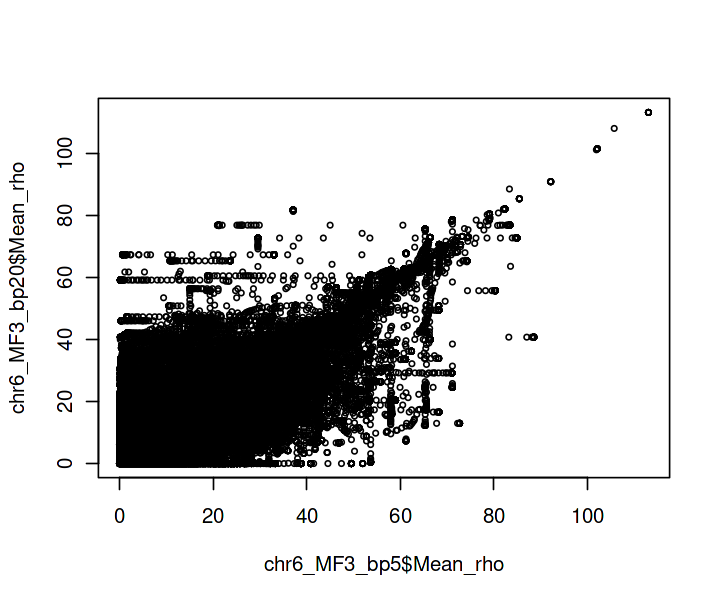

In [31]:
plot(chr6_MF3_bp5$Mean_rho, chr6_MF3_bp20$Mean_rho, color=alpha('black',0.4), cex=0.5)

Warning message in plot.window(...):
“"color" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"color" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"color" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"color" is not a graphical parameter”
Warning message in box(...):
“"color" is not a graphical parameter”
Warning message in title(...):
“"color" is not a graphical parameter”


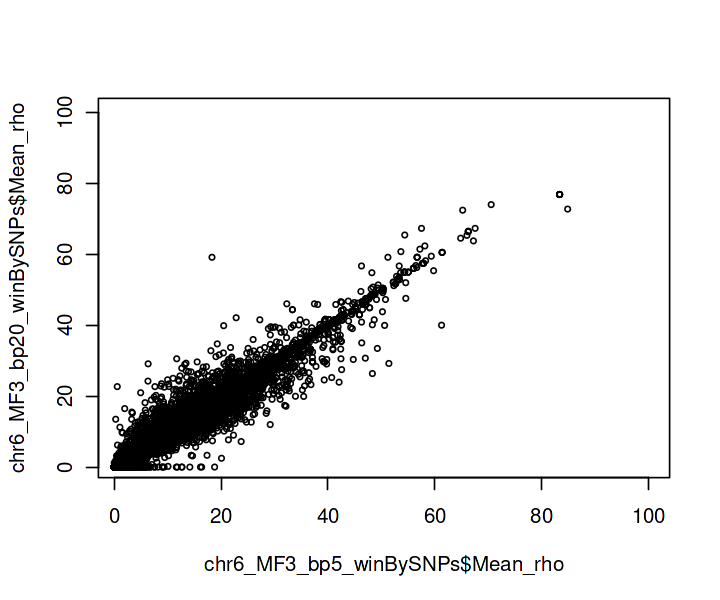

In [35]:
plot(chr6_MF3_bp5_winBySNPs$Mean_rho, chr6_MF3_bp20_winBySNPs$Mean_rho, color=alpha('black',0.4), cex=0.5, xlim=c(1,100), ylim=c(1,100))


In [27]:
cat('Correlation between MF3 & YF3')
cor(chr6_MF3_bp5_winBySNPs$Mean_rho, chr6_YF3_bp5_winBySNPs$Mean_rho)
cor(chr6_MF3_bp10_winBySNPs$Mean_rho, chr6_YF3_bp10_winBySNPs$Mean_rho)
cor(chr6_MF3_bp20_winBySNPs$Mean_rho, chr6_YF3_bp20_winBySNPs$Mean_rho)

Correlation between MF3 & YF3

[1] 0.7906893

[1] 0.7889959

[1] 0.7822252

In [29]:
cat('Correlation between different penalties')
cor(chr6_MF3_bp5$Mean_rho, chr6_MF3_bp10$Mean_rho)
cor(chr6_MF3_bp5$Mean_rho, chr6_MF3_bp20$Mean_rho)
cor(chr6_MF3_bp10$Mean_rho, chr6_MF3_bp20$Mean_rho)

Correlation between MF3 & YF3

[1] 0.9655703

[1] 0.9273323

[1] 0.950796

In [15]:
cat('Correlation between different penalties')
cor(chr6_YF3_bp5$Mean_rho, chr6_YF3_bp10$Mean_rho)
cor(chr6_YF3_bp5$Mean_rho, chr6_YF3_bp20$Mean_rho)
cor(chr6_YF3_bp10$Mean_rho, chr6_YF3_bp20$Mean_rho)

Correlation between different penalties

[1] 0.9664742

[1] 0.9261634

[1] 0.9513679

In [10]:
cat('Correlation between bpen5,10,20')
cor(chr6_MF3_bp5$Mean_rho, chr6_MF3_bp10$Mean_rho, chr6_MF3_bp20$Mean_rho)

Correlation between MF3 & YF3

ERROR: Error in if (is.na(na.method)) stop("invalid 'use' argument"): the condition has length > 1


### Plots

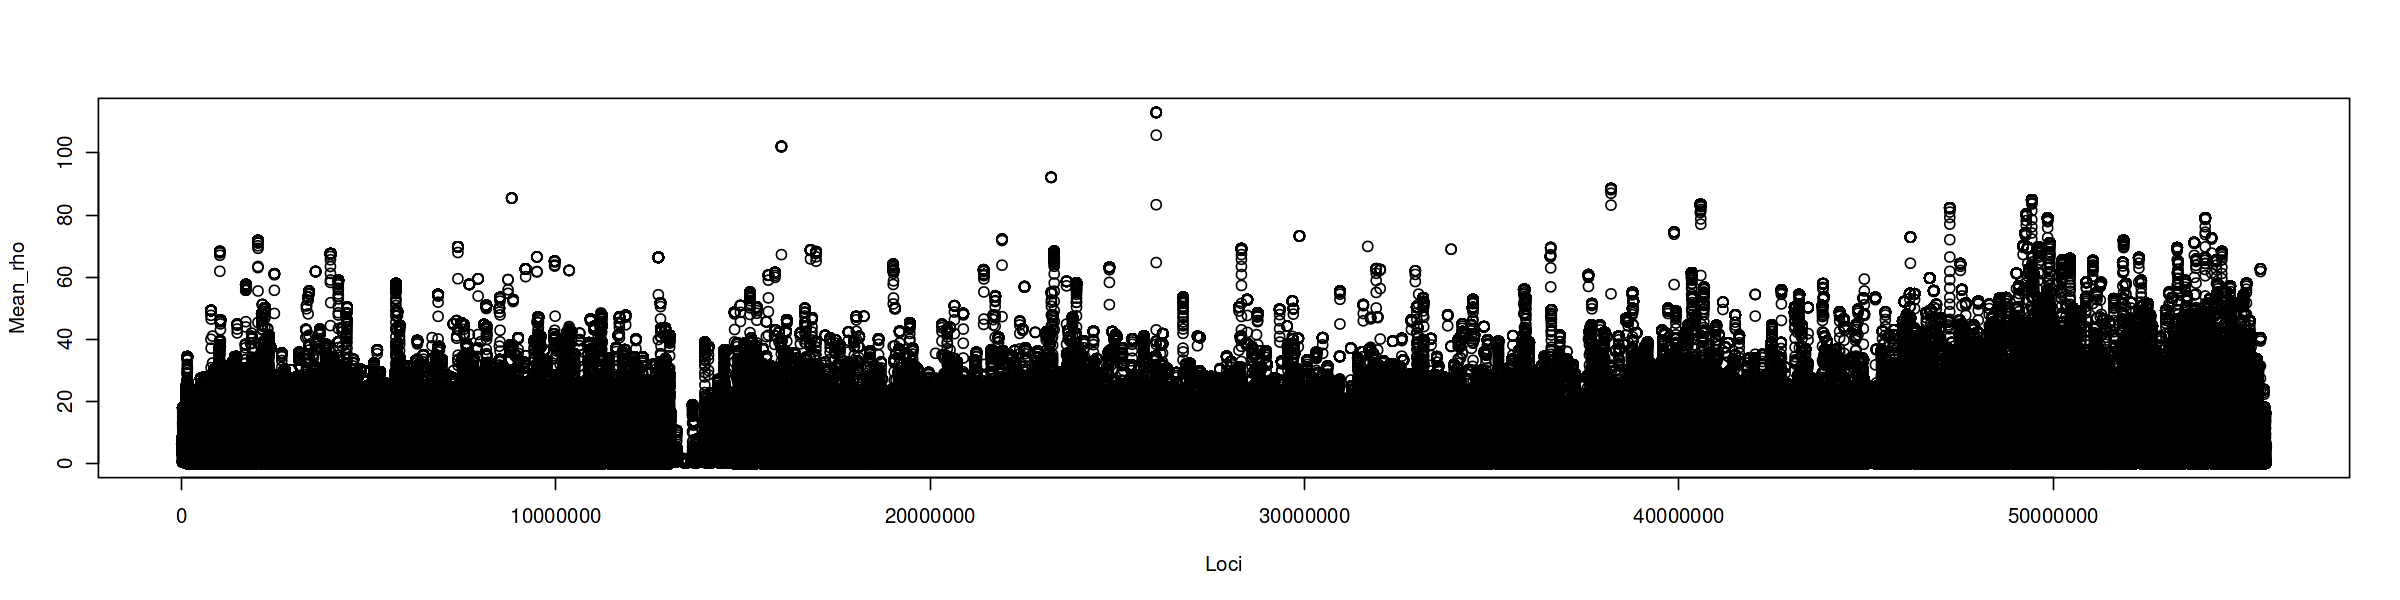

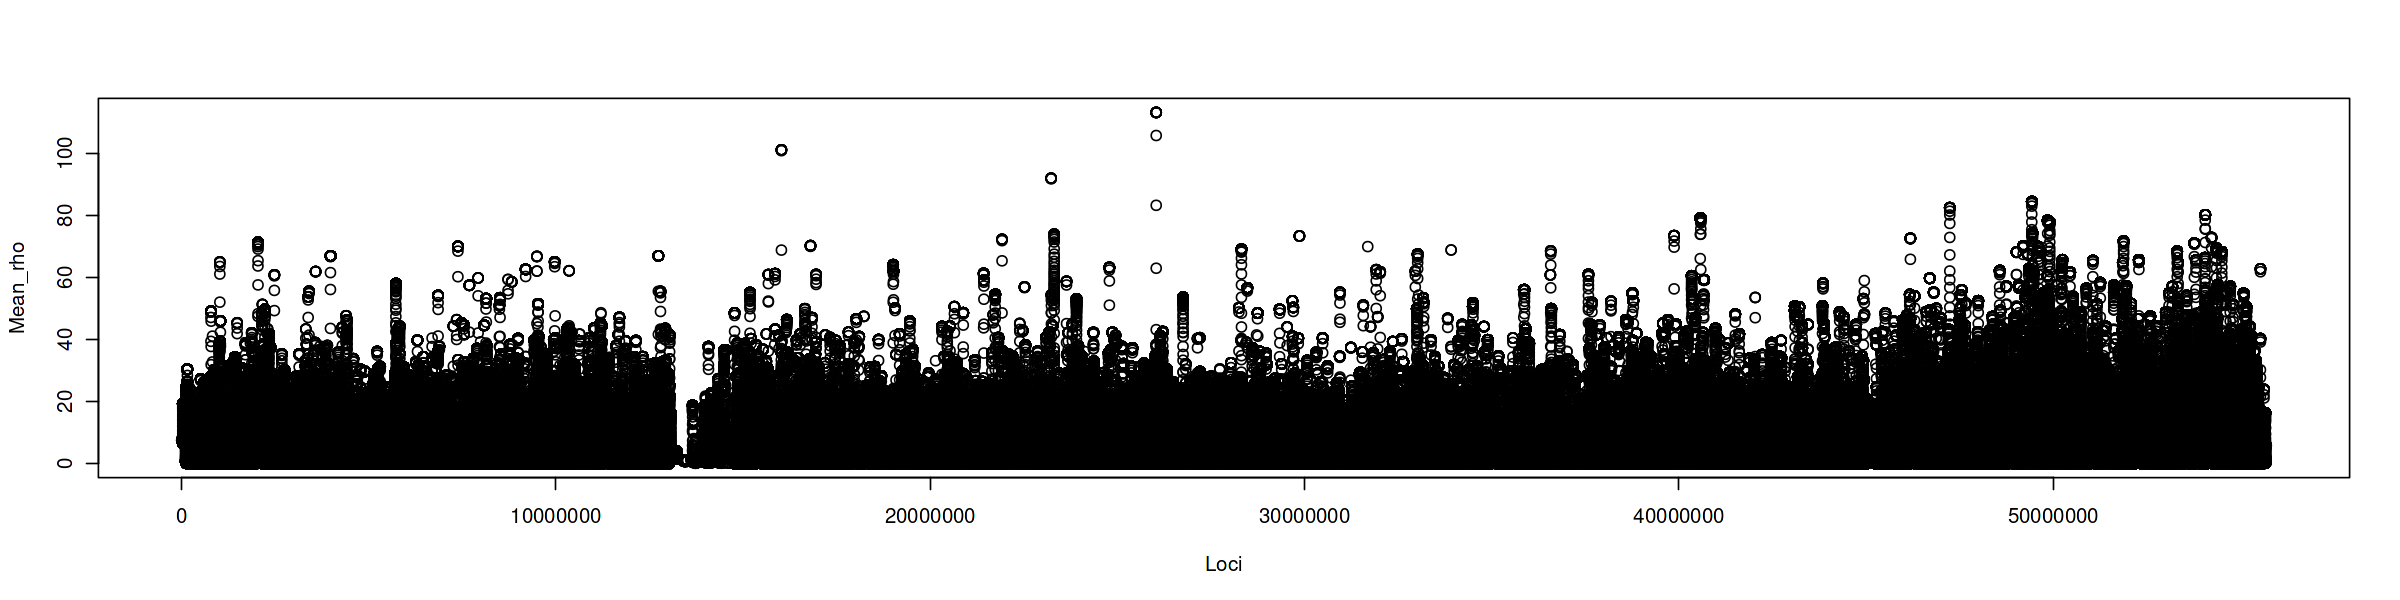

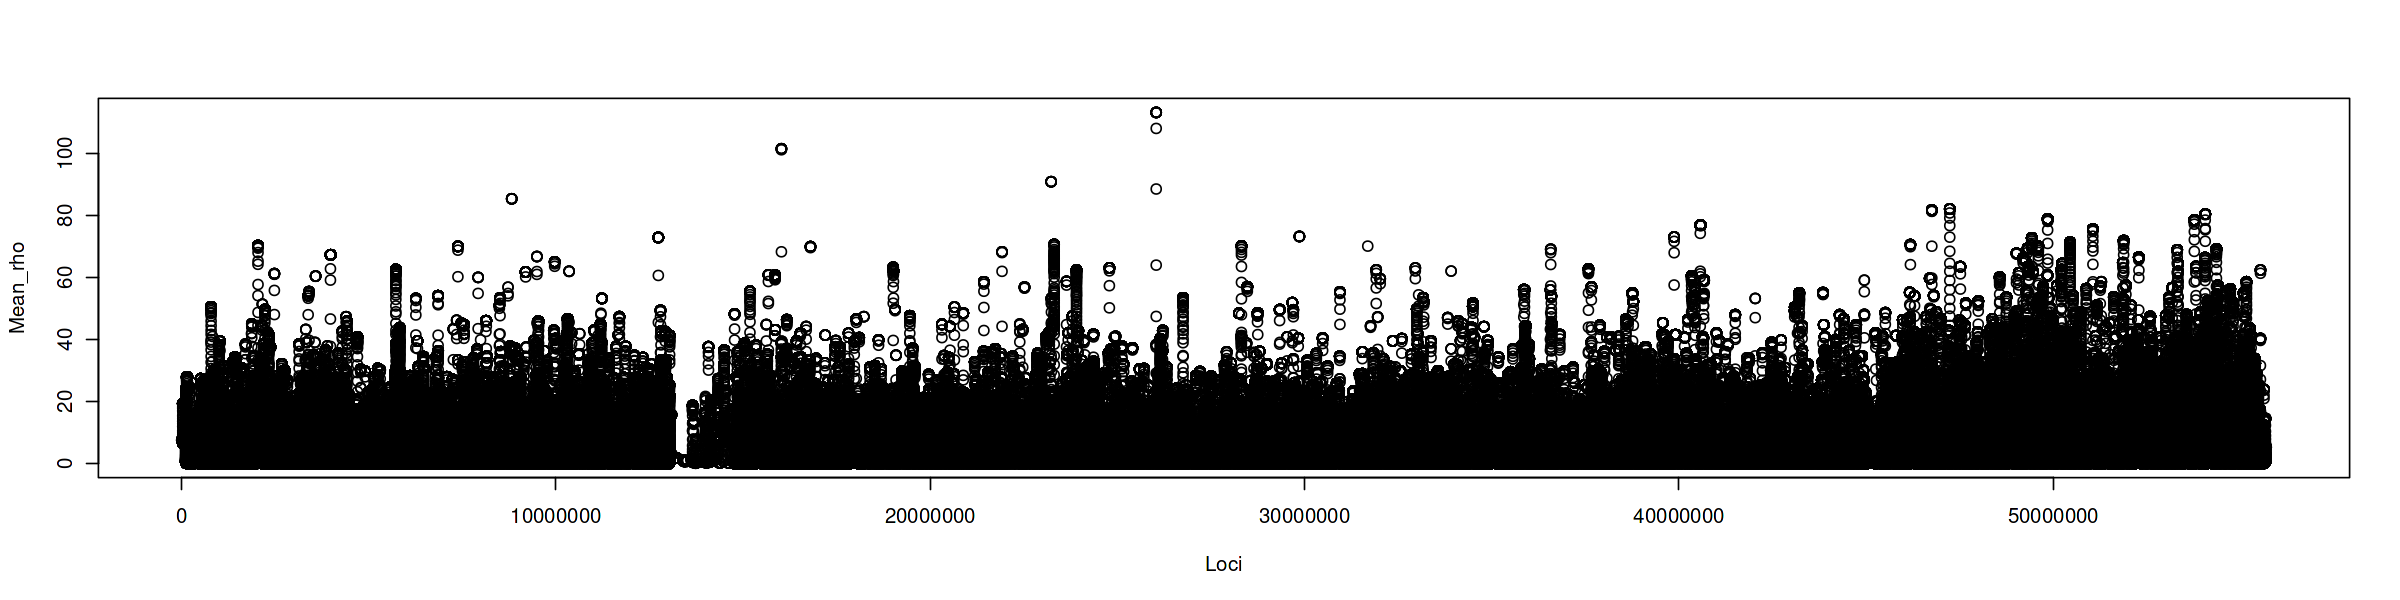

In [28]:
options(repr.plot.width=20, repr.plot.height=5)
plot(Mean_rho~Loci, chr6_MF3_bp5)
plot(Mean_rho~Loci, chr6_MF3_bp10)
plot(Mean_rho~Loci, chr6_MF3_bp20)

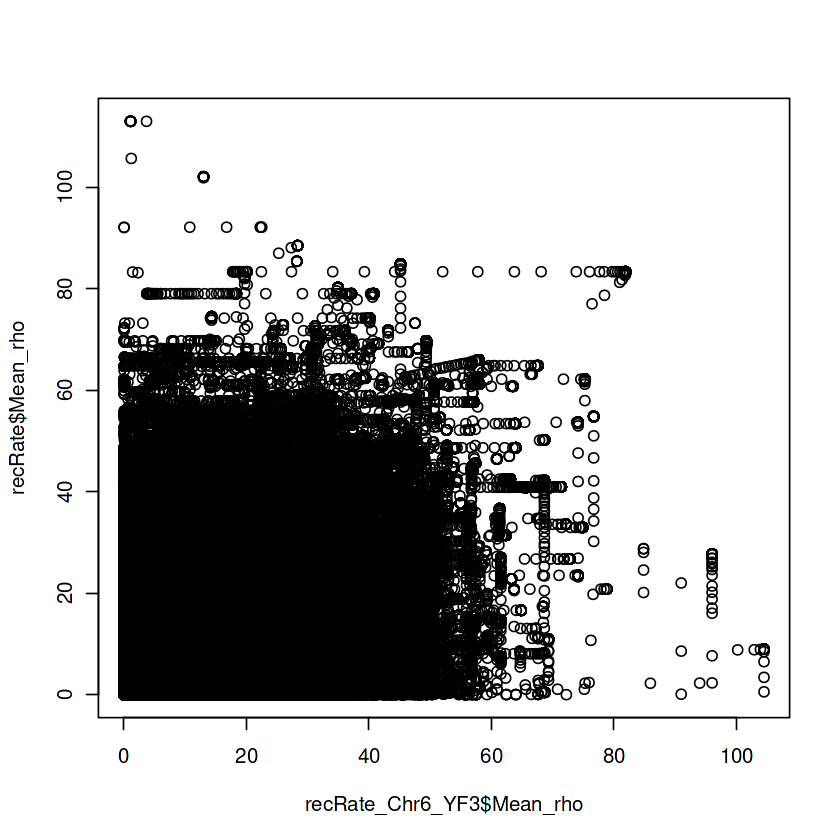

In [93]:
options(repr.plot.width=7, repr.plot.height=7)
# plot(recRate_Chr6_YF3$Mean_rho, recRate$Mean_rho)

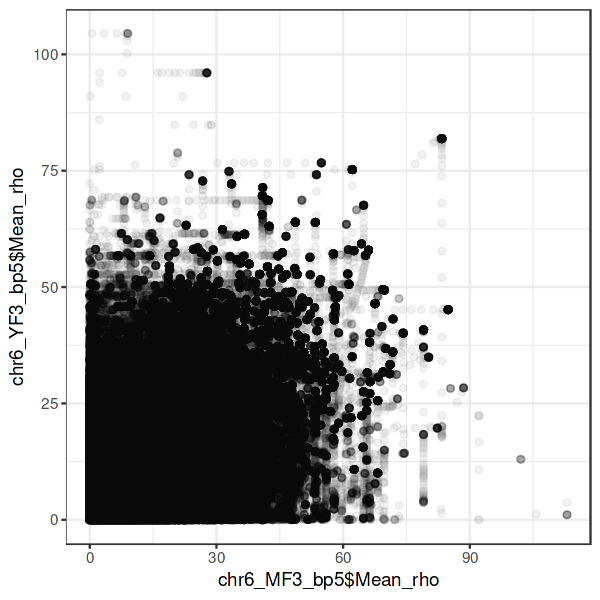

In [38]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot() +
    geom_point(aes(x = chr6_MF3_bp5$Mean_rho, y = chr6_YF3_bp5$Mean_rho), alpha=0.05) +
    geom_density_2d() +
    theme_bw()

In [14]:
options(repr.plot.width=6, repr.plot.height=5)
dat1=chr6_MF3_bp5[Mean_rho>=1]
dat2=chr6_YF3_bp5[Mean_rho>=1]

ggplot() + 
    stat_binhex(aes(x = dat1$Mean_rho, y = dat2$Mean_rho), bins=50) +
    theme_bw() +
    xlab('MF3') + ylab('YF3') #+ main('mean Rho')

ERROR while rich displaying an object: Error in `stat_binhex()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `check_aesthetics()`:
! Aesthetics must be either length 1 or the same as the data (1759346).
✖ Fix the following mappings: `x`.

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.

### misc3

In [ ]:
get_windowed_values <- function(data, window_size = 100) {
    # Load required package
    library(dplyr)

    # Ensure 'Position' is sorted
    data <- data %>% arrange(windowColName)
  
  # Initialize an empty list to store results
  results <- list()

  # Define window ranges
  max_position <- max(data$Position)
  window_starts <- seq(1, max_position, by = window_size)

  # Iterate over each window
  for (start in window_starts) {
    end <- start + window_size - 1
    window_data <- data %>% filter(Position >= start & Position <= end)
    
    if (nrow(window_data) > 0) {
      window_summary <- window_data %>%
        summarise(across(starts_with("Value"), list(
          mean = ~mean(.),
          median = ~median(.),
          max = ~max(.),
          min = ~min(.),
          perc_5 = ~quantile(., 0.05),
          perc_95 = ~quantile(., 0.95)
        )))
      results[[paste(start, end, sep = "-")]] <- window_summary
    }
  }

In [ ]:
get_windowed_values = function(data, columnID_toWindow, columnIDs_toCalculate, windowSize, stepSize, type){
    }

In [93]:
# rho=4*Ne*r
Ne=354349
rho=mean(recRate$Mean_rho)
r = rho/(4*Ne*1e3)
r*1e6

[1] 0.007231866

In [96]:
print('0.73cM/MB')
0.73*55

[1] "0.73cM/MB"


[1] 40.15

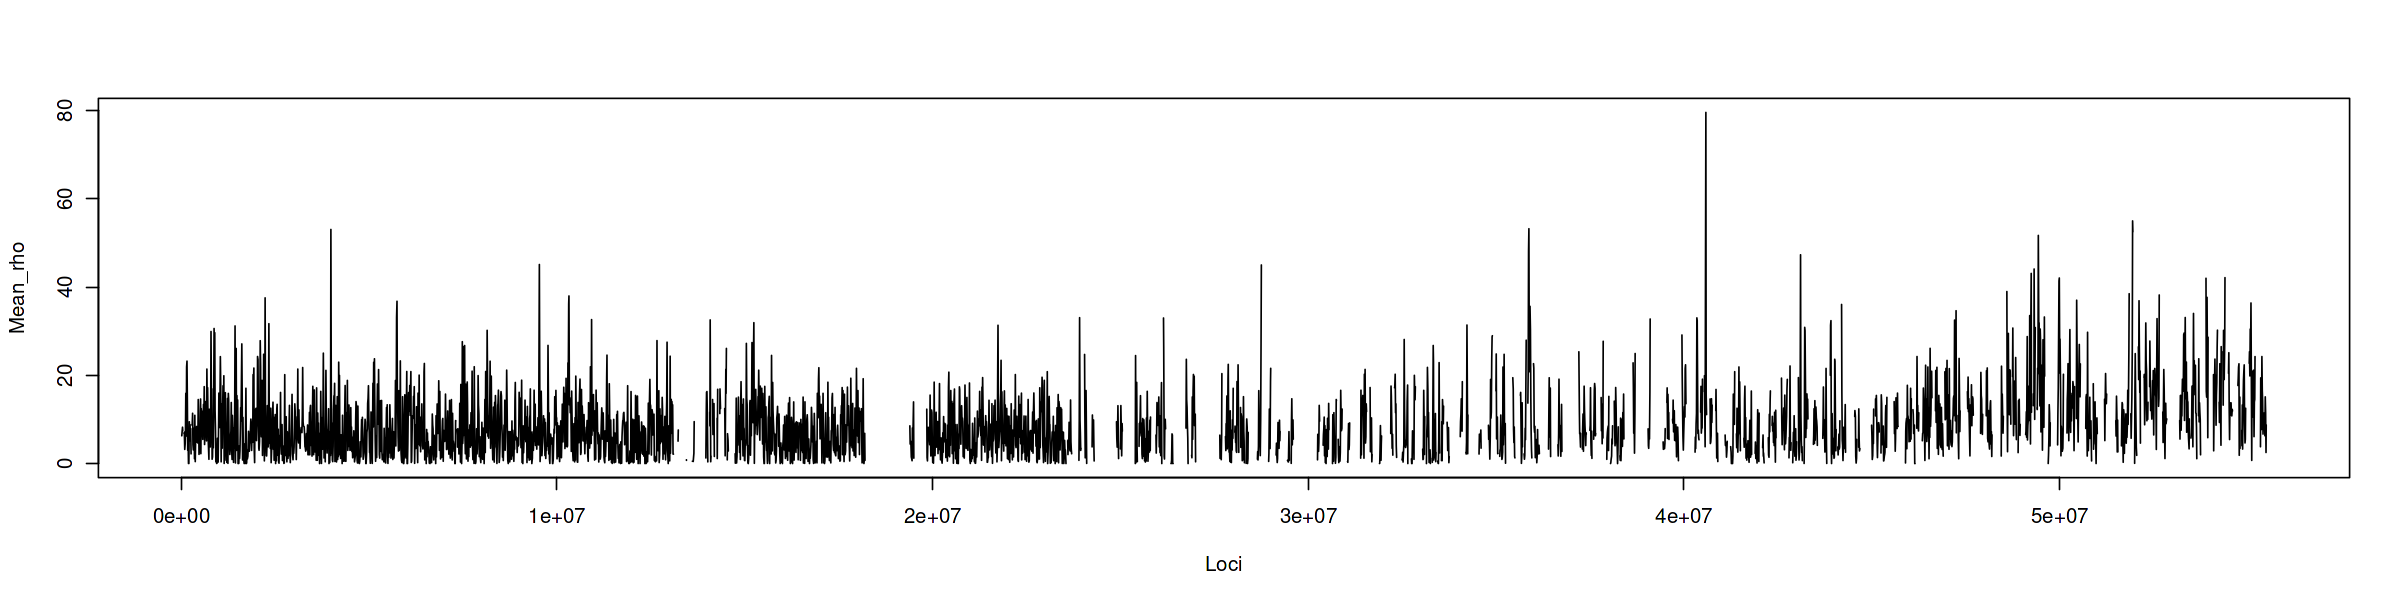

In [80]:
options(repr.plot.width=20, repr.plot.height=5)
plot(Mean_rho~Loci, recRate_windows, type='l')

In [90]:
mean(recRate$Mean_rho)
mean(recRate$Mean_rho)/(4*354349)
(mean(recRate$Mean_rho)/(4*354349))*1e6/

ERROR: Error in parse(text = x, srcfile = src): <text>:4:0: unexpected end of input
2: mean(recRate$Mean_rho)/(4*354349*1e3)
3: (mean(recRate$Mean_rho)/(4*354349))*1e6/
  ^


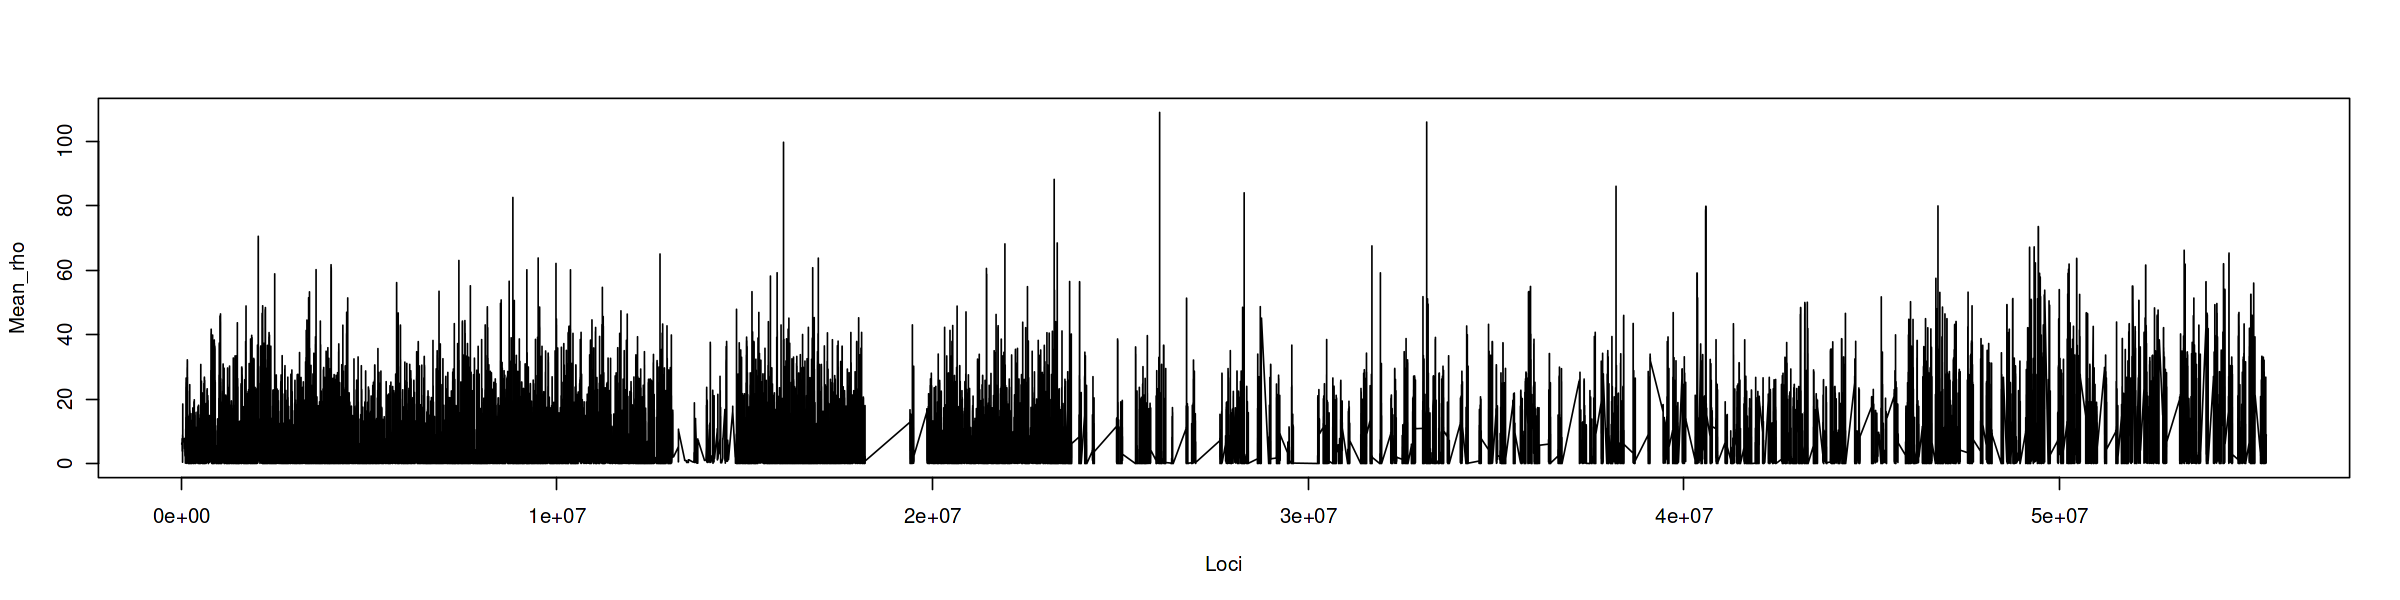

In [82]:
options(repr.plot.width=20, repr.plot.height=5)
plot(Mean_rho~Loci, recRate, type='l')

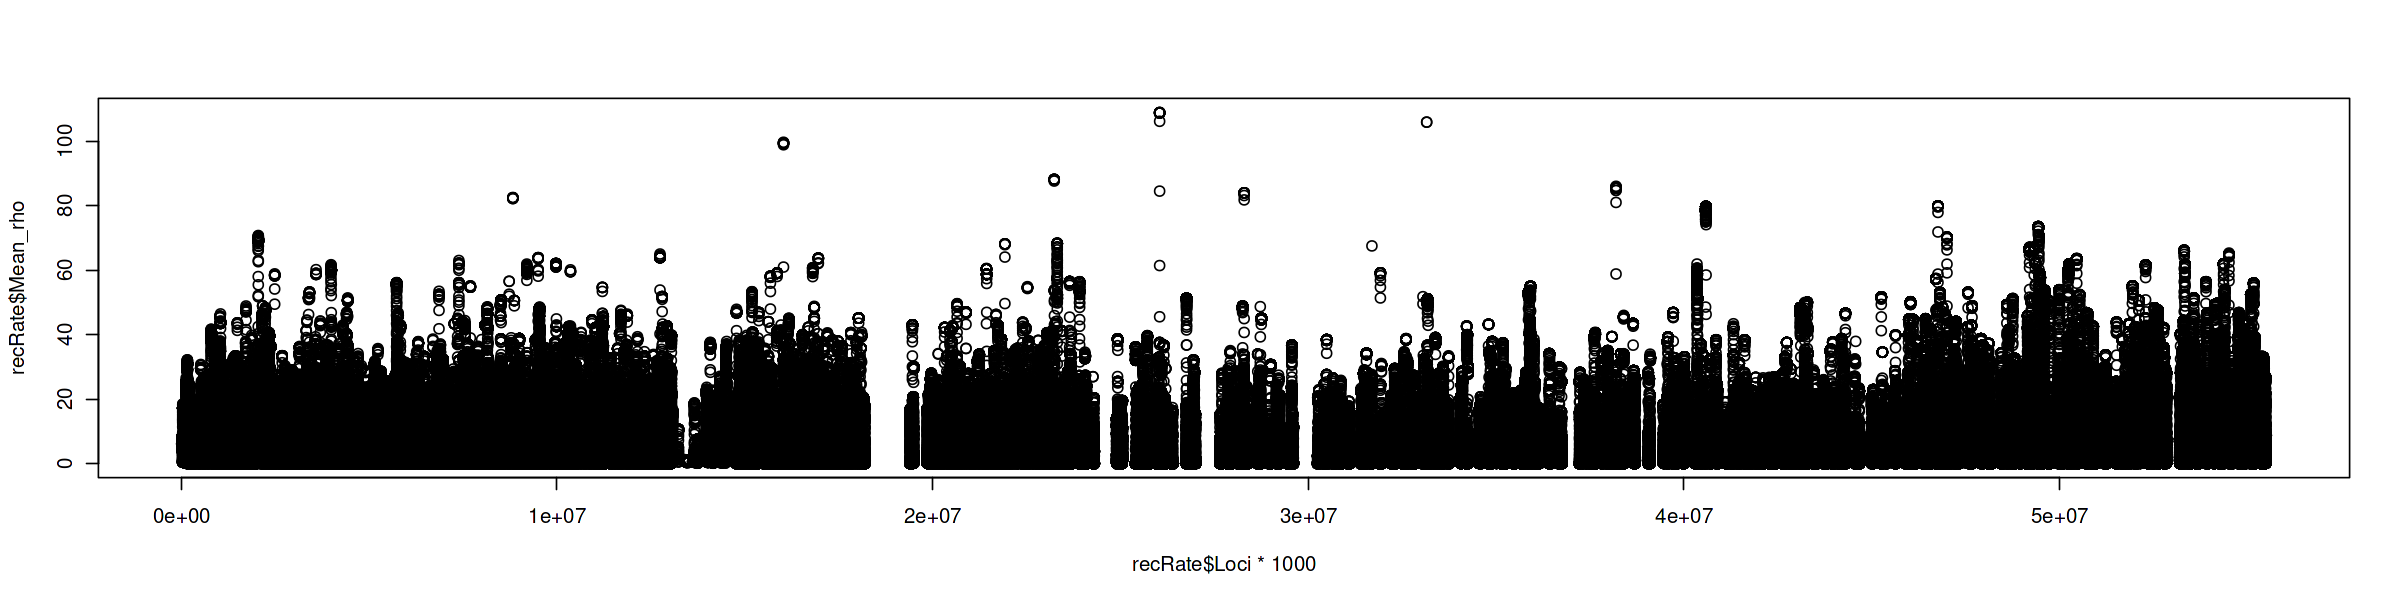

In [29]:
options(repr.plot.width=20, repr.plot.height=5)
plot($Loci*1000, recRate$Mean_rho)

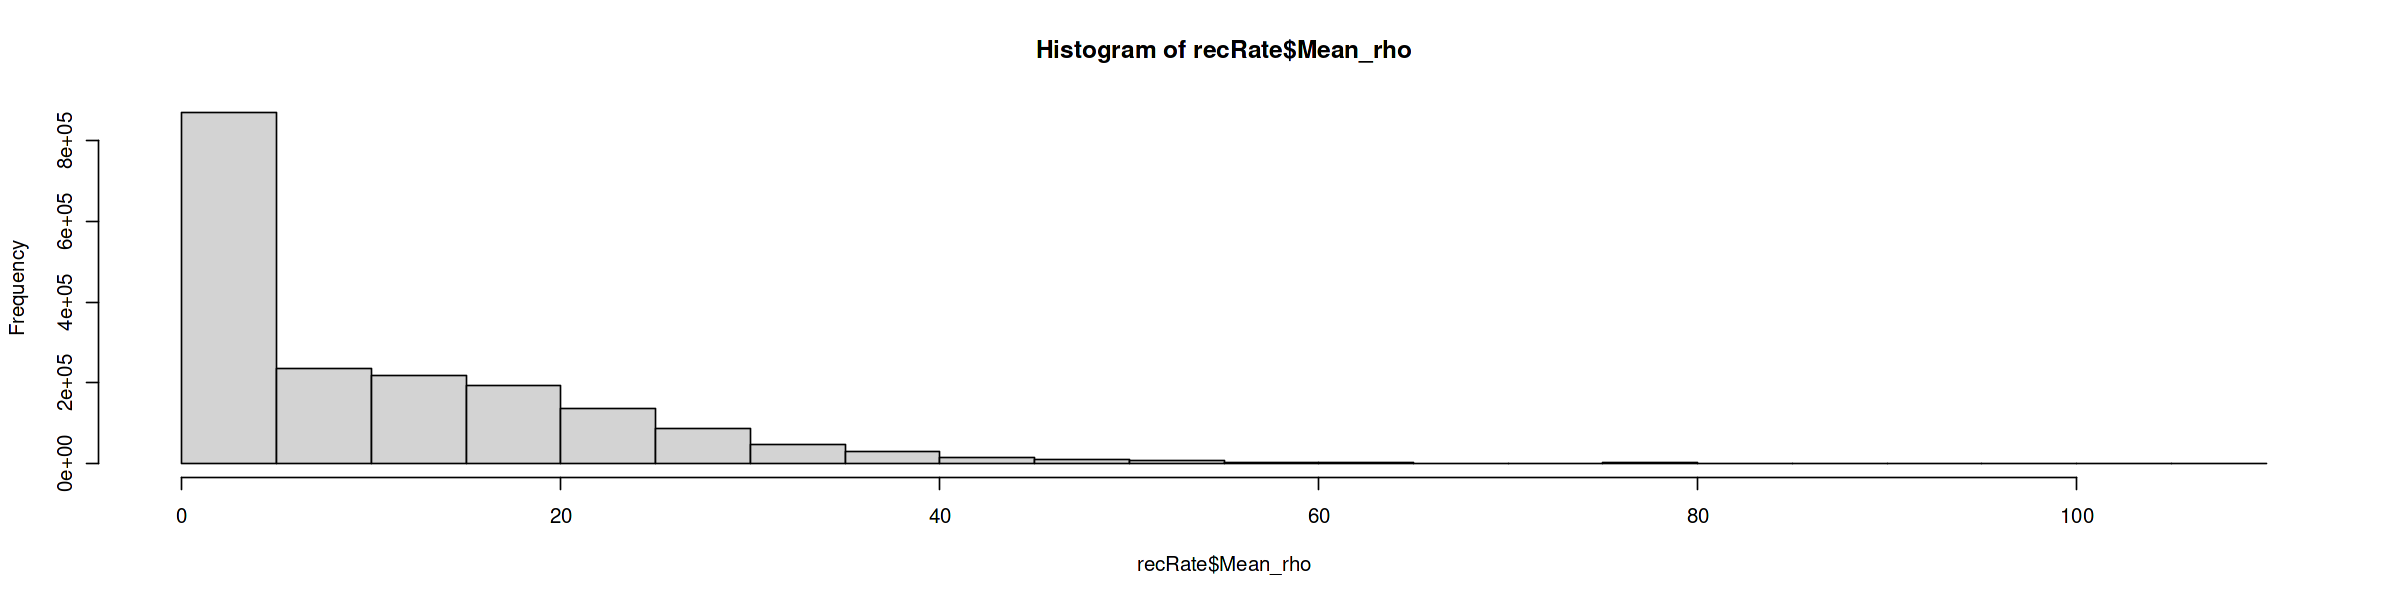

In [30]:
hist(recRate$Mean_rho)

In [35]:
a = data.frame(day=seq(1:10), obs=sample(10,replace = T))
a
# rollapply(obs, )

day,obs
<int>,<int>
1,6
2,8
3,1
4,5
5,1
6,9
7,5
8,3
9,8


In [43]:
rollapply(a, width=3, by=1, FUN=mean)

day,obs
2,5.000000
3,4.666667
4,2.333333
5,5.000000
6,5.000000
7,5.666667
8,5.333333
9,6.000000


In [ ]:
calculate_window_stats <- function(df, window_size, step_size) {
    results <- data.frame()
    window_start <- seq(1, max(pos), window_size)
    window_end <- seq(step_size, max(pos)+window_size, window_size)
    no_of_windows <- 
  
    for (start in seq(1, nrow(df) - window_size + 1, by = step_size)) {
    end <- start + window_size - 1
    window <- df[start:end, ]
    
    stats <- data.frame(
      start = start,
      end = end,
      mean_A = mean(window$A),
      median_A = median(window$A),
      min_A = min(window$A),
      max_A = max(window$A),
      mean_B = mean(window$B),
      median_B = median(window$B),
      min_B = min(window$B),
      max_B = max(window$B)
    )
    
    results <- rbind(results, stats)
  }
  
  return(results)
}

In [12]:
0.015/(4*1e-8)

375000.0

In [ ]:
recRate = pd.read_csv

In [4]:
rec6 = pd.read_csv('/Users/apal/Phd/Projects/2021-snap_hap/recRate/Chr6.MF1/MF1.Chr6.intervalres.txt', sep='\t')
rec6 = rec6[1:]
rec6.head()

,Loci,Mean_rho,Median,L95,U95
1,11.409,0.00179,0.00179,0.00179,0.00179
2,11.418,0.00179,0.00179,0.00179,0.00179
3,11.472,0.00179,0.00179,0.00179,0.00179
4,11.555,0.00179,0.00179,0.00179,0.00179
5,11.563,0.00179,0.00179,0.00179,0.00179


In [5]:
rec6['Loci'] = rec6['Loci']*1000

In [6]:
rec6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533822 entries, 1 to 2533822
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Loci      float64
 1   Mean_rho  float64
 2   Median    float64
 3   L95       float64
 4   U95       float64
dtypes: float64(5)
memory usage: 96.7 MB


In [7]:
rec6.head()

,Loci,Mean_rho,Median,L95,U95
1,11409.0,0.00179,0.00179,0.00179,0.00179
2,11418.0,0.00179,0.00179,0.00179,0.00179
3,11472.0,0.00179,0.00179,0.00179,0.00179
4,11555.0,0.00179,0.00179,0.00179,0.00179
5,11563.0,0.00179,0.00179,0.00179,0.00179


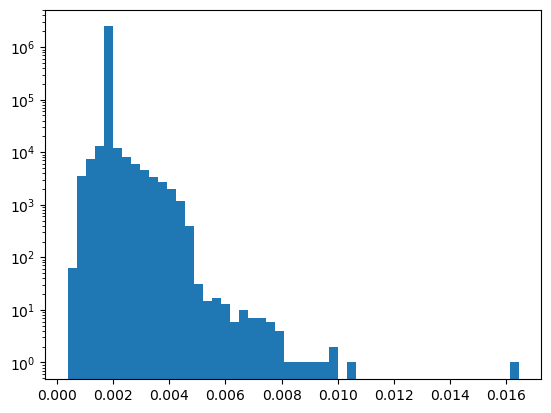

In [10]:
plt.hist(rec6['Mean_rho'], bins=50)
plt.yscale('log')
plt.show()

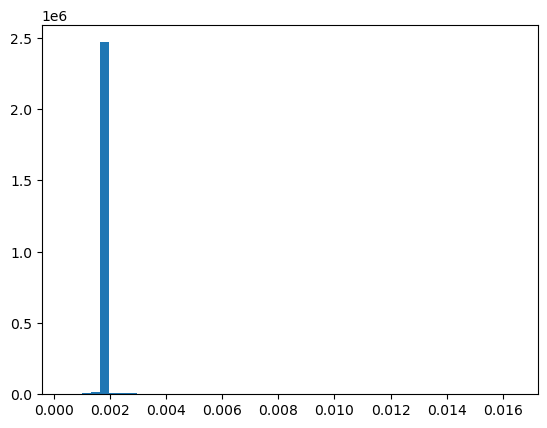

In [11]:
plt.hist(rec6['Mean_rho'], bins=50)
plt.show()

In [38]:
window_size = 10000
step_size = 10000
max_pos = float(np.max(rec6['Loci']))
bins = range(0, int(max_pos) + window_size, window_size)
labels = [f'{i+1}-{i+window_size}' for i in bins[:-1]]

In [41]:
rec6['bin'] = pd.cut(rec6['Loci'], bins=bins, labels=labels, right=True)

In [47]:
rec6_windowed = rec6.groupby(['bin']).mean().reset_index()

/var/folders/gk/63dm4mgd2cq_k27sk1qlnwbc0000gq/T/ipykernel_90594/222846619.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rec6_windowed = rec6.groupby(['bin']).mean().reset_index()


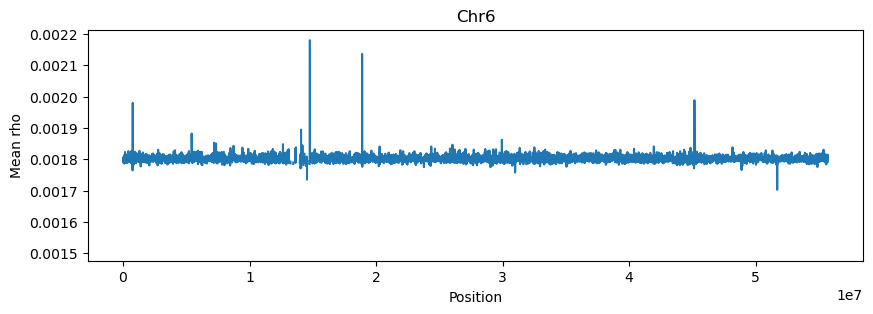

In [60]:
plt.figure(figsize=(10, 3))
plt.plot(rec6_windowed['Loci'],rec6_windowed['Mean_rho'])
plt.xlabel('Position')
plt.ylabel('Mean rho')
plt.title('Chr6')
plt.show()


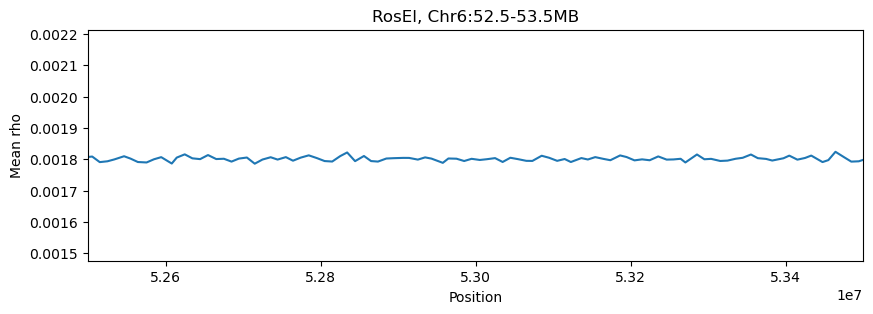

In [61]:
plt.figure(figsize=(10, 3))
plt.plot(rec6_windowed['Loci'],rec6_windowed['Mean_rho'])
plt.xlabel('Position')
plt.ylabel('Mean rho')
plt.title('RosEl, Chr6:52.5-53.5MB')
plt.xlim(52.5e6,53.5e6)
plt.show()


In [13]:
window_size = 100
step_size = 100
max_pos = float(np.max(rec6['Loci']))
bins = range(0, int(max_pos) + window_size, window_size)
labels = [f'{i+1}-{i+window_size}' for i in bins[:-1]]
rec6['bin2'] = pd.cut(rec6['Loci'], bins=bins, labels=labels, right=True)

In [14]:
rec6_w100b = rec6.groupby(['bin2']).mean().reset_index()

/var/folders/gk/63dm4mgd2cq_k27sk1qlnwbc0000gq/T/ipykernel_17165/271958468.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rec6_w100b = rec6.groupby(['bin2']).mean().reset_index()


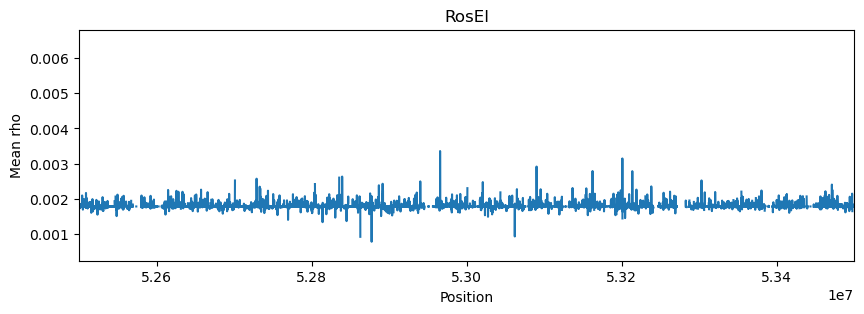

In [18]:
plt.figure(figsize=(10, 3))
plt.plot(rec6_w100b['Loci'],rec6_w100b['Mean_rho'])
plt.xlabel('Position')
plt.ylabel('Mean rho')
plt.title('RosEl')
plt.xlim(52.5e6,53.5e6)

plt.show()


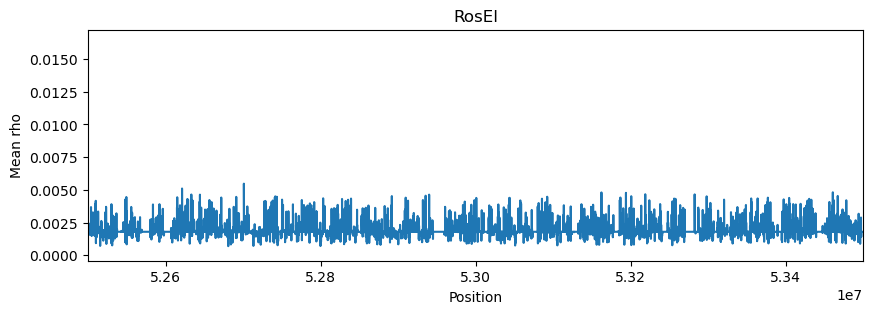

In [19]:
plt.figure(figsize=(10, 3))
plt.plot(rec6['Loci'],rec6['Mean_rho'])
plt.xlabel('Position')
plt.ylabel('Mean rho')
plt.title('RosEl')
plt.xlim(52.5e6,53.5e6)

plt.show()

In [20]:
0.018/(4*354349)

1.2699344431619673e-08

In [ ]:
window_size = 100
step_size = 100
max_pos = float(np.max(rec6['Loci']))
bins = range(0, int(max_pos) + window_size, window_size)
labels = [f'{i+1}-{i+window_size}' for i in bins[:-1]]
rec6['bin2'] = pd.cut(rec6['Loci'], bins=bins, labels=labels, right=True)
rec6_w100b = rec6.groupby(['bin2']).mean().reset_index()